In [1]:
import pandas as pd
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
import time
import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats
from scipy import stats
import centroid_minimize as cm
from statsmodels.stats.weightstats import DescrStatsW
from statsmodels.stats.descriptivestats import describe
import statsmodels.stats.weightstats
from numpy import std, sqrt, mean
from dataclasses import dataclass, astuple
from os import listdir
from os.path import isdir
from os import mkdir, getcwd
import shutil
from tqdm.notebook import tqdm

In [2]:
random.seed(0)

In [3]:
def extract_pad_sample(array,xmin,xmax,ymin,ymax,step,ox,oy,xspace,yspace,nxwell,nywell,name):
    x = []; y = []; v = []; iix = 0; iiy = 0;
    ixspace = int(xspace / step)
    iyspace = int(yspace / step)
    iiy = 0
    for iy in range(0,iyspace*nywell+1):
        if iiy >= iyspace:
            iix = 0
            for ix in range(0,ixspace*nxwell+1):
                if iix >= ixspace:
                    cx = ox + ix; cy = oy + iy 
                    x.append(step*(float(cx)-0.5)); y.append(step*(float(cy)-0.5)); v.append(array[ny-cy+1,cx])
                    iix = 0; iiy = 0
                iix = iix + 1
        iiy = iiy + 1
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)

In [4]:
por = np.load('data/por.npy')

In [5]:
x = np.arange(200)
y = np.arange(200)
coords = np.array(list(itertools.product(x, y)))
coords = np.hstack([coords, por.flatten().reshape(-1,1)])
data = pd.DataFrame(data=coords, columns=['x','y','z'])

In [6]:
x_min = data['x'].min()
x_max = data['x'].max()
y_min = data['y'].min()
y_max = data['y'].max()

In [7]:
def get_samples(df, x, ymin, ymax, num_samples):
    x_step = np.unique(df['x'].values)[1] - np.unique(df['x'].values)[0]
    tmp = df.loc[(df['x'] < x+x_step/2) & (df['x'] > x-x_step/2)]
    out = pd.DataFrame(columns=tmp.columns)
    y_step = df['y'][1] - df['y'][0]
    
    well_step = (ymax - ymin) / num_samples
    for i in range(num_samples):
        well_pos = well_step * i + ymin
        out = out.append(tmp.loc[(tmp['y'] < well_pos+y_step/2) & (tmp['y'] > well_pos-y_step/2)])
    return out

In [8]:
def get_pad(df, num_ywells, num_xwells, xmin, xmax, ymin, ymax):
    sampled = pd.DataFrame(columns=data.columns)
    for i in range(num_xwells):
        x = i * ((xmax-xmin)/num_xwells) + xmin
        sampled = sampled.append(get_samples(data, x, ymin, ymax, num_ywells))
    return sampled

In [9]:
def get_random_pad():
    num_ywells = random.randint(2, 5)
    num_xwells = random.randint(2, 5)
    x_1 = random.randint(x_min, x_max)
    x_2 = random.randint(x_min, x_max)
    while abs(x_2 - x_1) < num_xwells or abs(x_2-x_1) > (x_max-x_min)/4:
        x_2 = random.randint(x_min, x_max)
    y_1 = random.randint(y_min, y_max)
    y_2 = random.randint(y_min, y_max)
    while abs(y_2 - y_1) < num_ywells or abs(y_2-y_1) > (y_max-y_min)/4:
        y_2 = random.randint(y_min, y_max)
    
    return get_pad(data, num_ywells, num_xwells, min(x_1, x_2), max(x_1, x_2), 
                   min(y_1, y_2), max(y_1, y_2))

In [10]:
def get_pads(num_pads):
    output = pd.DataFrame(columns=data.columns)
    for _ in range(num_pads):
        output = output.append(get_random_pad())
    return output

In [11]:
def get_random_samples(num_samples):
    return data.sample(n=num_samples)

In [12]:
def bartlett_test(v1, v2):
    p_value = stats.bartlett(v1, v2)
    return p_value.pvalue
def t_test(v1, v2):
    return stats.ttest_ind(v1,v2).pvalue

In [13]:
def plot_data(dat):
    plt.scatter(dat['x'], dat['y'])
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])

In [14]:
def find_ave(dirname):
    ave = 0
    num = 0
    for f in listdir(dirname):
        if f.startswith('cm'):
            tmp = pd.read_csv('{}/{}'.format(dirname, f))
            ave+=len(tmp)
            num+=1
    return ave / num

In [15]:
@dataclass
class StatsRepr:
    name: str
    t_prob: float
    bartlett_prob: float
    
    def tolist(self):
        return list(astuple(self))[1:]

    def get_headers(self):
        output = ['_t_prob', '_bartlett_prob']
        return [self.name + output[i] for i in range(len(output))]

In [16]:
def get_stats(data, sampled):
    if data is None:
        biased_tmp = StatsRepr('biased', 0, 0)
        cm_tmp = StatsRepr('cm', 0, 0)
        declus_tmp = StatsRepr('declus', 0, 0)
        return biased_tmp.get_headers() + cm_tmp.get_headers() + declus_tmp.get_headers()
        
    cm_points = cm.centroid_minimize(sampled[['x','y']].values, width=x_max-x_min,
                                     height=y_max-y_min)
    cm_df = pd.DataFrame(columns=data.columns)
    for point in cm_points:
        cm_df = cm_df.append(data.loc[(data['x'] == point[0]) & (data['y']==point[1])])
        
    
    # try:
    wts, cell_sizes, dmeans = geostats.declus(sampled, 'x','y','z', iminmax=1, noff=10, ncell=100, cmin=1, cmax=200)
    sampled['wts'] = wts
    weighted = sampled['z']*sampled['wts']

    biased_t_prob = t_test(sampled['z'], data['z'])
    biased_b_prob = bartlett_test(sampled['z'], data['z'])
    biased_stats = StatsRepr('biased', biased_t_prob, biased_b_prob)

    cm_t_prob  = t_test(cm_df['z'], data['z'])
    cm_b_prob = bartlett_test(cm_df['z'], data['z'])
    cm_stats = StatsRepr('cm', cm_t_prob, cm_b_prob)

    declus_t_prob = t_test(weighted, data['z'])
    declus_b_prob = bartlett_test(weighted, data['z'])
    declus_stats = StatsRepr('declus', declus_t_prob, declus_b_prob)

    return biased_stats.tolist() +  cm_stats.tolist() + declus_stats.tolist(), cm_df

In [17]:
def do_analysis(num_tests, test_name, num_samples=None, num_pads = None):
    
    statistics = pd.DataFrame(columns = ['test_num']+get_stats(None, None))
    statistics.set_index('test_num')
    if not isdir('results'):
        mkdir('results')
    if isdir('results/'+test_name):
        shutil.rmtree(getcwd() + '/results/'+test_name)
    mkdir('results/'+test_name)
    for test_num in tqdm(range(num_tests)):
        worked = False
        while not worked:
            #try:
            if num_samples is None:
                sampled = get_pads(random.randint(num_pads[0], num_pads[1]))
            elif num_pads is None:
                sampled = get_random_samples(num_samples) # g
            stats, cm_df = get_stats(data, sampled)
            # print(cm_df)
            # if s != False:
            #    s = [test_num] + s
            if stats != False:
                stats = [test_num] + stats

            tmp = pd.DataFrame(data=np.array(stats).reshape(1,-1),columns=statistics.columns)
            tmp.set_index('test_num')
            statistics = statistics.append(tmp, ignore_index=True)
            sampled.to_csv('results/'+test_name+'/sample_'+str(test_num)+'.csv')
            cm_df.to_csv('results/'+test_name+'/cm_'+str(test_num)+'.csv')
            worked = True
            #except Exception as e:
             #   print(e)
    statistics.to_csv('results/'+test_name+'/stats'+'.csv')
    return statistics

In [18]:
num_repetitions = 1_000

In [19]:
def analyze(stats):
    print('Better t against declus : {}'.format((stats['cm_t_prob'] > stats['declus_t_prob']).value_counts()[1]))
    print('Better bartlett agnst dc: {}'.format((stats['cm_bartlett_prob'] > stats['declus_bartlett_prob']).value_counts()[1]))
    print('Better t against sample : {}'.format((stats['cm_t_prob'] > stats['biased_t_prob']).value_counts()[1]))
    print('Better bartlett agnst sm: {}'.format((stats['cm_bartlett_prob'] > stats['biased_bartlett_prob']).value_counts()[1]))
    return stats

In [20]:
stats_100 = do_analysis(num_repetitions, '1000x100', num_samples=100)

There are 100 data with:
   mean of      10.110439651582023 
   min and max  6.377494282229328 and 14.73508100294379
   standard dev 1.6468714974223584 
There are 100 data with:
   mean of      10.127004600833049 
   min and max  5.42743825198378 and 14.842345158435236
   standard dev 2.113751461334115 
There are 100 data with:
   mean of      9.913937144717584 
   min and max  4.922731097215078 and 15.248677018967483
   standard dev 2.074030488475299 
There are 100 data with:
   mean of      10.102410673239206 
   min and max  4.881033371620734 and 14.424096411290094
   standard dev 2.0419452576692554 
There are 100 data with:
   mean of      9.864035437573866 
   min and max  5.2925677669538 and 14.99497859511979
   standard dev 1.988704159026026 
There are 100 data with:
   mean of      9.754743478837314 
   min and max  6.235610634974565 and 14.116563808465639
   standard dev 1.8300350688529585 
There are 100 data with:
   mean of      10.248477962028321 
   min and max  5.87634430

There are 100 data with:
   mean of      10.199019438979441 
   min and max  5.718400949136798 and 14.43923234635038
   standard dev 1.9454654806602378 
There are 100 data with:
   mean of      10.628091532019017 
   min and max  6.6436287682967645 and 16.084961932703635
   standard dev 2.013751842390495 
There are 100 data with:
   mean of      10.11076466439638 
   min and max  6.098975032723756 and 14.717986731905498
   standard dev 1.9105636279960934 
There are 100 data with:
   mean of      9.68054780702642 
   min and max  4.8047882120847065 and 14.788487226326133
   standard dev 2.031881017357688 
There are 100 data with:
   mean of      10.375595442527436 
   min and max  5.411457583679287 and 15.873311343644602
   standard dev 2.132356562225708 
There are 100 data with:
   mean of      9.97961206030255 
   min and max  5.232117242786632 and 15.759089117226907
   standard dev 1.9092046897031052 
There are 100 data with:
   mean of      9.95094691961552 
   min and max  3.656347

There are 100 data with:
   mean of      9.88479185392055 
   min and max  4.87824407522315 and 14.305678064300624
   standard dev 2.2268548774832073 
There are 100 data with:
   mean of      10.043934138218546 
   min and max  4.695374098707303 and 15.24142712384392
   standard dev 1.9813246294581275 
There are 100 data with:
   mean of      10.00641211606732 
   min and max  6.0893639964031845 and 14.788487226326133
   standard dev 1.7866500227742723 
There are 100 data with:
   mean of      9.56297181366182 
   min and max  4.770861952494624 and 15.439287921746011
   standard dev 2.0427137129353783 
There are 100 data with:
   mean of      9.740101965344444 
   min and max  3.182300167497983 and 14.727007932040664
   standard dev 2.1754707281734764 
There are 100 data with:
   mean of      9.974364401531913 
   min and max  5.538992542545591 and 16.077806650897124
   standard dev 2.1050382467572732 
There are 100 data with:
   mean of      10.051033315831083 
   min and max  5.24055

There are 100 data with:
   mean of      10.163333687926267 
   min and max  6.027189074670628 and 14.77337264912434
   standard dev 1.767729291400592 
There are 100 data with:
   mean of      9.906442977849652 
   min and max  3.2788646347043198 and 13.887214141721348
   standard dev 1.9653982268788401 
There are 100 data with:
   mean of      9.99007514211483 
   min and max  5.963096736221656 and 14.564048469791501
   standard dev 1.9789319520634274 
There are 100 data with:
   mean of      9.947533156726104 
   min and max  4.7350436261696975 and 14.394243314880853
   standard dev 2.01903940380453 
There are 100 data with:
   mean of      10.005023574180075 
   min and max  3.612055610609315 and 15.40746511180798
   standard dev 2.159591575974722 
There are 100 data with:
   mean of      9.878075679708239 
   min and max  4.685252270238354 and 14.365352918952905
   standard dev 1.9019539553475517 
There are 100 data with:
   mean of      10.096204439292176 
   min and max  3.887812

There are 100 data with:
   mean of      10.426947859326246 
   min and max  3.031087327812255 and 16.084961932703635
   standard dev 2.148572906586707 
There are 100 data with:
   mean of      9.620081396824224 
   min and max  4.021654624672094 and 15.148524231928645
   standard dev 2.117502446883067 
There are 100 data with:
   mean of      9.709035436029808 
   min and max  4.704563766436542 and 14.123114084019033
   standard dev 1.8518649264916565 
There are 100 data with:
   mean of      9.758473525965568 
   min and max  5.419179946569636 and 14.664085684867105
   standard dev 2.0341473783779405 
There are 100 data with:
   mean of      9.77771695436934 
   min and max  4.894340914309337 and 14.608939893851662
   standard dev 1.9184954365035147 
There are 100 data with:
   mean of      9.924201845600836 
   min and max  5.918862016408529 and 14.787167031222825
   standard dev 2.146124237109106 
There are 100 data with:
   mean of      10.082133170323312 
   min and max  4.608243

There are 100 data with:
   mean of      10.165400224236585 
   min and max  5.7623915506234455 and 15.140714641148948
   standard dev 2.1209939169318117 
There are 100 data with:
   mean of      9.715652209365434 
   min and max  3.574524463875939 and 14.019793746920566
   standard dev 1.870470199020712 
There are 100 data with:
   mean of      9.915929761693242 
   min and max  5.920990217223688 and 14.605404070437693
   standard dev 1.8588404075342966 
There are 100 data with:
   mean of      10.107937351547626 
   min and max  2.8942110005395856 and 14.52416815823036
   standard dev 2.2531793824430864 
There are 100 data with:
   mean of      9.898026924828267 
   min and max  5.70005315145067 and 15.215271731439637
   standard dev 1.79933400209476 
There are 100 data with:
   mean of      9.748640427698742 
   min and max  5.391901969154618 and 15.257981260629183
   standard dev 2.0038346189993916 
There are 100 data with:
   mean of      9.823282681599837 
   min and max  5.04181

There are 100 data with:
   mean of      9.876417344532165 
   min and max  4.265382521515655 and 16.03160461282905
   standard dev 2.0950866822176315 
There are 100 data with:
   mean of      10.291733501463494 
   min and max  4.0959508297193565 and 15.984844875166383
   standard dev 2.2222849115134995 
There are 100 data with:
   mean of      9.885272634169814 
   min and max  3.6240673101454117 and 15.192511040898363
   standard dev 2.1286985156395066 
There are 100 data with:
   mean of      10.058469098157826 
   min and max  5.056281985960213 and 14.843674735027786
   standard dev 1.8200151410214025 
There are 100 data with:
   mean of      10.017631647482181 
   min and max  6.311573152196367 and 15.791929519338613
   standard dev 1.9261083252536124 
There are 100 data with:
   mean of      10.040197455343383 
   min and max  4.798515588691685 and 15.095696666787077
   standard dev 1.9517497354706612 
There are 100 data with:
   mean of      10.099855490089272 
   min and max  

There are 100 data with:
   mean of      9.870607967494832 
   min and max  5.087495198703582 and 14.852313290165517
   standard dev 2.140164458097795 
There are 100 data with:
   mean of      9.894890334267986 
   min and max  4.0761421145912715 and 16.362057790724222
   standard dev 2.2005691276491595 
There are 100 data with:
   mean of      10.219533678606593 
   min and max  3.725122516606997 and 15.447620879861795
   standard dev 2.0044128865290514 
There are 100 data with:
   mean of      10.080355089321515 
   min and max  5.8223662137192065 and 15.18900455958905
   standard dev 1.9369161661271999 
There are 100 data with:
   mean of      10.3593317293031 
   min and max  3.4200289013796574 and 15.06492657970584
   standard dev 2.179780271683797 
There are 100 data with:
   mean of      9.839628392611111 
   min and max  4.975972246307969 and 15.536410288153096
   standard dev 2.046418149413661 
There are 100 data with:
   mean of      10.119009609032876 
   min and max  3.2000

There are 100 data with:
   mean of      9.60451866725257 
   min and max  3.2000050337617107 and 14.660606349994751
   standard dev 2.0096187370513876 
There are 100 data with:
   mean of      10.31990375905456 
   min and max  5.991796907484734 and 15.084161826353156
   standard dev 1.7825167407074334 
There are 100 data with:
   mean of      9.96303929319246 
   min and max  6.356709892219935 and 14.441140581183706
   standard dev 1.9964449977409828 
There are 100 data with:
   mean of      10.289421535930645 
   min and max  5.571532138183045 and 15.047481001836307
   standard dev 1.8840341378154613 
There are 100 data with:
   mean of      9.77508273542212 
   min and max  5.470160955179498 and 14.200981043557235
   standard dev 1.6397916465024402 
There are 100 data with:
   mean of      9.917695663326333 
   min and max  6.276851661688296 and 13.779258350905899
   standard dev 1.732853179028164 
There are 100 data with:
   mean of      10.087012242253556 
   min and max  5.66738

There are 100 data with:
   mean of      9.733392042555398 
   min and max  5.140123357297191 and 15.791929519338613
   standard dev 2.060994598379734 
There are 100 data with:
   mean of      10.09456360985726 
   min and max  4.040403031909528 and 15.871627266522344
   standard dev 2.1048483933582256 
There are 100 data with:
   mean of      10.07561185196804 
   min and max  5.929094825899165 and 16.068563289112426
   standard dev 1.9850248725802155 
There are 100 data with:
   mean of      10.334141866360206 
   min and max  6.194061815571189 and 15.164616280467135
   standard dev 1.8017594235968066 
There are 100 data with:
   mean of      9.816151439572076 
   min and max  5.4465798833448185 and 15.333942181001753
   standard dev 1.7939339686271965 
There are 100 data with:
   mean of      10.026619068770895 
   min and max  5.903755223846744 and 15.564349361150539
   standard dev 2.002173008064151 
There are 100 data with:
   mean of      9.71094436807745 
   min and max  3.5413

There are 100 data with:
   mean of      9.813244969451718 
   min and max  3.8878129097604157 and 15.016852235912182
   standard dev 1.9456030417743342 
There are 100 data with:
   mean of      10.352622779013203 
   min and max  4.344650516649581 and 14.660606349994751
   standard dev 1.988769590041178 
There are 100 data with:
   mean of      10.111775990052614 
   min and max  6.07053454906718 and 14.503913922166294
   standard dev 1.9818625580501676 
There are 100 data with:
   mean of      9.991197470030842 
   min and max  5.301008711998959 and 14.403015406535687
   standard dev 2.0251365488006696 
There are 100 data with:
   mean of      10.175887981170609 
   min and max  6.749924235122295 and 15.873249465736826
   standard dev 1.9414189230047676 
There are 100 data with:
   mean of      10.11976877582553 
   min and max  6.177693911327715 and 15.436269876695814
   standard dev 1.9072246236011476 
There are 100 data with:
   mean of      9.962079209783388 
   min and max  4.12

There are 100 data with:
   mean of      10.11933524427511 
   min and max  5.0573712367432115 and 15.536410288153096
   standard dev 2.1740610741465765 
There are 100 data with:
   mean of      10.05350676743675 
   min and max  5.405208513812451 and 15.619592959181498
   standard dev 1.9685115268268571 
There are 100 data with:
   mean of      10.304439776715263 
   min and max  3.9858714290302926 and 14.345098682888839
   standard dev 1.9393053239642484 
There are 100 data with:
   mean of      9.733949609571582 
   min and max  3.2096619794977297 and 14.67627722954806
   standard dev 2.27064778397904 
There are 100 data with:
   mean of      10.093705559108018 
   min and max  5.836203910353136 and 15.214511231992464
   standard dev 1.990171639003617 
There are 100 data with:
   mean of      9.94578279194901 
   min and max  4.121700822024636 and 15.723314504649732
   standard dev 2.1456388748730353 
There are 100 data with:
   mean of      9.77517050013625 
   min and max  4.71107

There are 100 data with:
   mean of      10.34001520422547 
   min and max  6.1013235987330585 and 15.158195349701607
   standard dev 2.1028665424129267 
There are 100 data with:
   mean of      9.93933978184256 
   min and max  5.0561159136399905 and 16.137183094349005
   standard dev 2.0693178927394658 
There are 100 data with:
   mean of      10.109347420519459 
   min and max  6.612415755159548 and 14.717986731905498
   standard dev 1.755545026994672 
There are 100 data with:
   mean of      10.187220326035561 
   min and max  3.698844765630243 and 15.692372157457495
   standard dev 2.277692301301481 
There are 100 data with:
   mean of      10.137824195089891 
   min and max  3.4488336662674923 and 15.369971491031578
   standard dev 2.1103251937640524 
There are 100 data with:
   mean of      10.077748832683445 
   min and max  5.561850441283916 and 14.382854586151746
   standard dev 1.803214194542884 
There are 100 data with:
   mean of      9.984536316494452 
   min and max  4.6

There are 100 data with:
   mean of      9.699896088383262 
   min and max  5.430212178707499 and 14.798415436825593
   standard dev 1.8376809920440613 
There are 100 data with:
   mean of      10.091052610702176 
   min and max  4.632870625245076 and 14.800465591634495
   standard dev 1.9788941114646257 
There are 100 data with:
   mean of      9.966555612510255 
   min and max  5.842019236047084 and 14.647254095527625
   standard dev 2.0020560433470735 
There are 100 data with:
   mean of      9.832012340850682 
   min and max  3.3038487381962645 and 14.452288984103262
   standard dev 2.1325590250685207 
There are 100 data with:
   mean of      10.157525468313205 
   min and max  3.7608386445810176 and 15.368777047805361
   standard dev 1.9783208070734488 
There are 100 data with:
   mean of      10.166617360097622 
   min and max  3.9402578299045468 and 15.604217696342431
   standard dev 1.9885202543258018 
There are 100 data with:
   mean of      9.907910813126524 
   min and max  

There are 100 data with:
   mean of      10.17988254257579 
   min and max  4.745431529642081 and 14.663433172349308
   standard dev 1.952667364539137 
There are 100 data with:
   mean of      9.786961499459238 
   min and max  5.508907703391425 and 14.302489555594812
   standard dev 2.0633853075877022 
There are 100 data with:
   mean of      9.849122686412095 
   min and max  4.8468224736548855 and 14.72127384605144
   standard dev 1.8995802181989085 
There are 100 data with:
   mean of      9.96582054568817 
   min and max  5.000305833343657 and 15.984269410624073
   standard dev 2.2169762304586125 
There are 100 data with:
   mean of      9.982948294713745 
   min and max  4.805804407015299 and 14.984942397690954
   standard dev 2.024083437625935 
There are 100 data with:
   mean of      10.096785029840287 
   min and max  3.7817400037967213 and 14.145947630806557
   standard dev 1.8624308853046516 
There are 100 data with:
   mean of      10.494713169711387 
   min and max  5.2477

There are 100 data with:
   mean of      9.69798515800695 
   min and max  6.240446293664122 and 14.485288272713639
   standard dev 1.811246700611002 
There are 100 data with:
   mean of      10.079231511429846 
   min and max  2.8942110005395856 and 14.555465604770767
   standard dev 2.246545386853675 
There are 100 data with:
   mean of      10.29641292036551 
   min and max  5.140123357297191 and 14.728021132878943
   standard dev 1.9260499314117954 
There are 100 data with:
   mean of      10.227040427166802 
   min and max  5.508907703391425 and 14.68310296159413
   standard dev 1.9487290308804754 
There are 100 data with:
   mean of      10.200476713189916 
   min and max  6.4128878466583 and 15.217735070987555
   standard dev 1.7881396879249596 
There are 100 data with:
   mean of      10.068479589112291 
   min and max  4.961303190042155 and 14.961053133954323
   standard dev 1.9389927180478448 
There are 100 data with:
   mean of      9.644171871358823 
   min and max  4.13439

There are 100 data with:
   mean of      10.138159516202792 
   min and max  6.177693911327715 and 15.564503457101514
   standard dev 1.9141005346425572 
There are 100 data with:
   mean of      10.025281451194129 
   min and max  5.056281985960213 and 14.717844412717614
   standard dev 1.978679651057343 
There are 100 data with:
   mean of      10.165269118704867 
   min and max  5.653592224200712 and 15.047657054464235
   standard dev 1.942532264554349 
There are 100 data with:
   mean of      10.123958802920438 
   min and max  5.824855502067158 and 15.604217696342431
   standard dev 2.0638382196280323 
There are 100 data with:
   mean of      9.76122959428597 
   min and max  4.831402898249605 and 14.681053804815999
   standard dev 2.1857184885263177 
There are 100 data with:
   mean of      10.045610766195624 
   min and max  6.359200178598657 and 14.842345158435236
   standard dev 1.8828927596611074 
There are 100 data with:
   mean of      10.017783063275417 
   min and max  5.7

There are 100 data with:
   mean of      9.934702649208273 
   min and max  4.124759387124119 and 15.564503457101514
   standard dev 2.0982742165237047 
There are 100 data with:
   mean of      10.169706760495517 
   min and max  5.538992542545591 and 14.520097390323368
   standard dev 1.8800972914687768 
There are 100 data with:
   mean of      9.866784462996712 
   min and max  5.104821212486803 and 15.351717508237883
   standard dev 1.9217418289543906 
There are 100 data with:
   mean of      9.855582589612528 
   min and max  3.583908747605439 and 15.984844875166383
   standard dev 2.030930035005274 
There are 100 data with:
   mean of      9.925221658552655 
   min and max  3.6939254719621113 and 15.352001547795187
   standard dev 2.1115915790888122 
There are 100 data with:
   mean of      10.135314000318717 
   min and max  6.203923158009021 and 14.728848101175437
   standard dev 1.9875736772873913 
There are 100 data with:
   mean of      9.998509040303624 
   min and max  5.31

There are 100 data with:
   mean of      10.047258345062334 
   min and max  5.8035405589001305 and 14.826841748445226
   standard dev 1.8561628721287133 
There are 100 data with:
   mean of      9.886975707729913 
   min and max  3.787934780789638 and 15.47610108514304
   standard dev 2.2047505084666765 
There are 100 data with:
   mean of      9.983489931512302 
   min and max  4.770861952494624 and 14.793912521594942
   standard dev 2.0585412165359354 
There are 100 data with:
   mean of      10.188596645473108 
   min and max  4.862769408519334 and 14.715448340443633
   standard dev 2.1017089889201515 
There are 100 data with:
   mean of      9.878371877258425 
   min and max  5.424551946995297 and 14.443141233666388
   standard dev 1.8989294849763345 
There are 100 data with:
   mean of      9.550365809451758 
   min and max  3.728277691085073 and 14.71419142049118
   standard dev 1.904642627416988 
There are 100 data with:
   mean of      9.85869110853897 
   min and max  5.60897

In [21]:
analyze(stats_100)

Better t against declus : 748
Better bartlett agnst dc: 998
Better t against sample : 506
Better bartlett agnst sm: 484


,test_num,biased_t_prob,biased_bartlett_prob,cm_t_prob,cm_bartlett_prob,declus_t_prob,declus_bartlett_prob
0,0.0,0.581145,0.012471,0.857901,0.120176,0.680474,8.178991e-138
1,1.0,0.526005,0.387740,0.852197,0.522540,0.119844,6.392998e-74
2,2.0,0.667397,0.556296,0.749787,0.819895,0.032637,1.925075e-68
3,3.0,0.609092,0.715370,0.569334,0.705884,0.075321,1.458364e-80
4,4.0,0.497163,0.992711,0.506978,0.956116,0.055061,2.096068e-96
...,...,...,...,...,...,...,...
995,995.0,0.591343,0.779127,0.852029,0.481226,0.552783,5.375176e-74
996,996.0,0.598807,0.255880,0.443821,0.648192,0.518048,5.009284e-51
997,997.0,0.918836,0.489725,0.676243,0.426424,0.417524,9.853253e-62
998,998.0,0.827776,0.671584,0.610092,0.687624,0.777313,2.484808e-107


<AxesSubplot:>

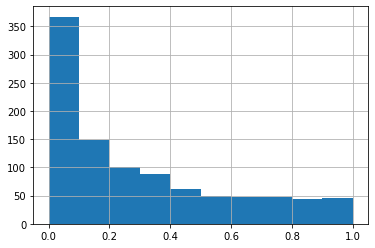

In [27]:
stats_100['declus_t_prob'].hist()

<AxesSubplot:>

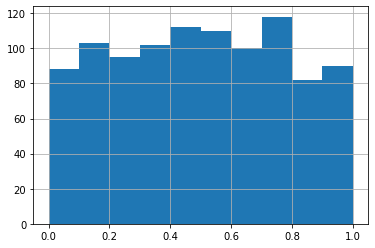

In [26]:
stats_100['cm_t_prob'].hist()

In [29]:
print((stats_100['cm_t_prob'] > stats_100['declus_t_prob']).value_counts())

True     748
False    252
dtype: int64


In [30]:
print((stats_100['cm_bartlett_prob'] > stats_100['declus_bartlett_prob']).value_counts())

True     998
False      2
dtype: int64
